In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
train_data_cols = ['transaction_id', 'client_id', 'transaction_value', 'merchant_id', 'date', 'time', 'fraud_flag']
train_data = pd.read_csv('transaction_one_base.csv', names=train_data_cols)
train_data.shape

(100000, 7)

In [76]:
train_data

,transaction_id,client_id,transaction_value,merchant_id,date,time,fraud_flag
0,1,340,29756,2023,0,22,0
1,2,227,3318,84,0,66,0
2,3,430,12191,814,0,128,0
3,4,142,2884,510,0,197,0
4,5,452,34639,1993,0,242,0
...,...,...,...,...,...,...,...
99995,99996,55,12942,9,47,46151,0
99996,99997,285,31791,4860,47,46173,0
99997,99998,396,32133,4774,47,46209,0
99998,99999,254,36451,3559,47,46236,0


<h3>Looking for patterns in transaction value</h3>

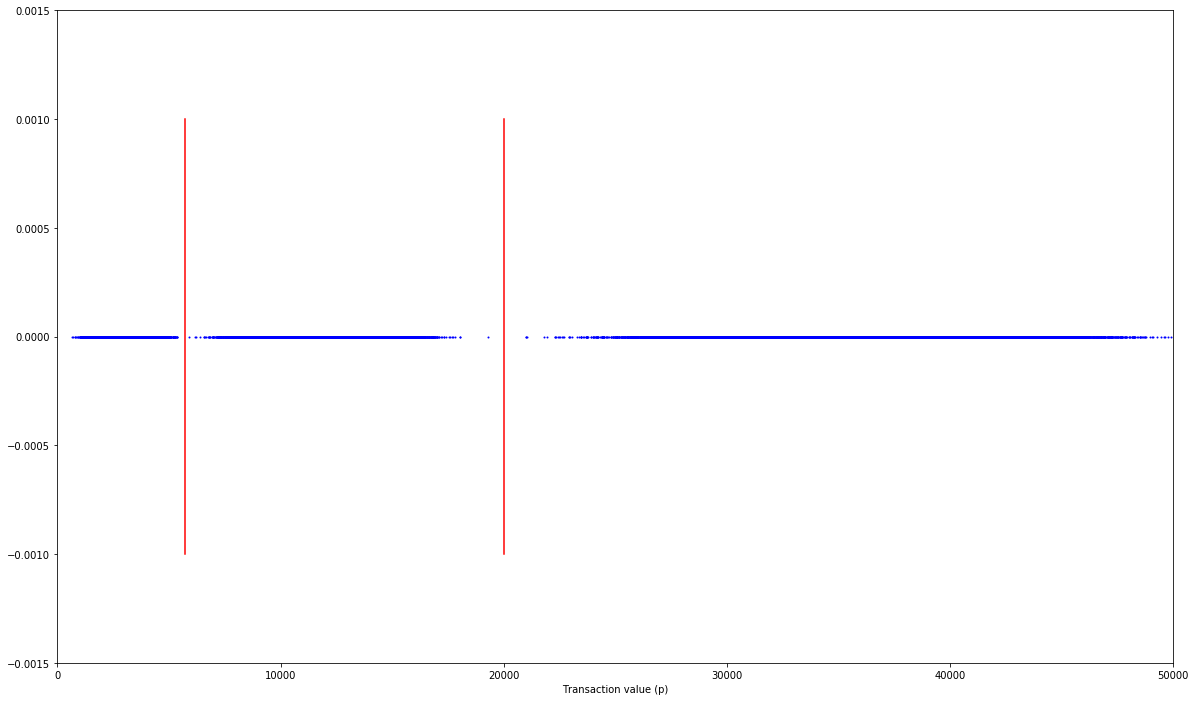

In [3]:
# Plot transaction values on a linear scale
plt.rcParams['figure.figsize'] = (20, 12)
plt.scatter(train_data['transaction_value'], np.zeros(len(train_data['transaction_value'])), c='b', marker='o', s=1)
#   Add two vertical lines to show the gaps between the bands
plt.plot([5700, 5700], [-0.001, 0.001], 'r')
plt.plot([20000, 20000], [-0.001, 0.001], 'r')
plt.axis([0, 50000, -0.0015, 0.0015])
plt.xlabel('Transaction value (p)')
# plt.savefig('Just transaction value.png', format='png')
plt.show()

The transaction value is clearly separated into three bands, separated by the red vertical lines in the above plot. They presumably represent different kinds of shopping, e.g. groceries vs luxury goods.

The lowest price transactions are below £57 and the highest price transactions are above £200.

Below is a more detailed summary of the price bands.

In [4]:
# Generate statistics about transaction value data
high_band_mask = train_data['transaction_value'] > 20000
mid_band_mask = train_data[train_data['transaction_value'] < 20000] > 5700
low_band_mask = train_data['transaction_value'] < 5700

print('All price bands')
print('Max transaction value:', max(train_data['transaction_value']))
print('Min transaction value:', min(train_data['transaction_value']))
print('\nHigh price band')
print('Max transaction value:', max(train_data[high_band_mask].transaction_value))
print('Min transaction value:', min(train_data[high_band_mask].transaction_value))
print('Mean transaction value:', np.mean(train_data[high_band_mask].transaction_value))
print('Standard deviation transaction value:', np.std(train_data[high_band_mask].transaction_value))
print('\nMiddle price band')
print('Max transaction value:', max(train_data[mid_band_mask].transaction_value))
print('Min transaction value:', min(train_data[mid_band_mask].transaction_value))
print('Mean transaction value:', np.mean(train_data[mid_band_mask].transaction_value))
print('Standard deviation transaction value:', np.std(train_data[mid_band_mask].transaction_value))
print('\nLow price band')
print('Max transaction value:', max(train_data[low_band_mask].transaction_value))
print('Min transaction value:', min(train_data[low_band_mask].transaction_value))
print('Mean transaction value:', np.mean(train_data[low_band_mask].transaction_value))
print('Standard deviation transaction value:', np.std(train_data[low_band_mask].transaction_value))

All price bands
Max transaction value: 49903
Min transaction value: 651

High price band
Max transaction value: 49903
Min transaction value: 20986
Mean transaction value: 36039.156795921874
Standard deviation transaction value: 4107.434781404458

Middle price band
Max transaction value: 19289.0
Min transaction value: 5897.0
Mean transaction value: 11995.685903500473
Standard deviation transaction value: 1639.4275140500886

Low price band
Max transaction value: 5368
Min transaction value: 651
Mean transaction value: 3129.444782135773
Standard deviation transaction value: 676.2224422862612


<h3>Looking for patterns in merchant behaviour</h3>

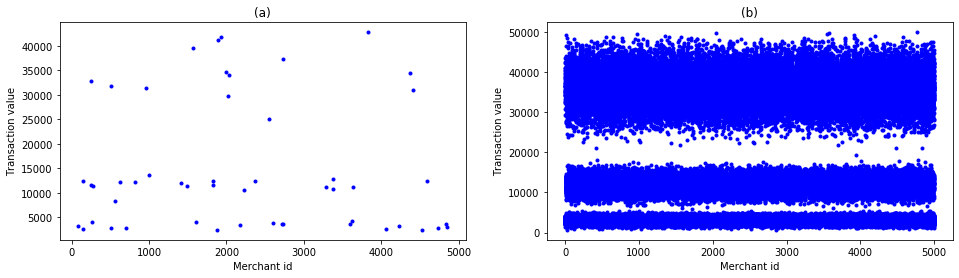

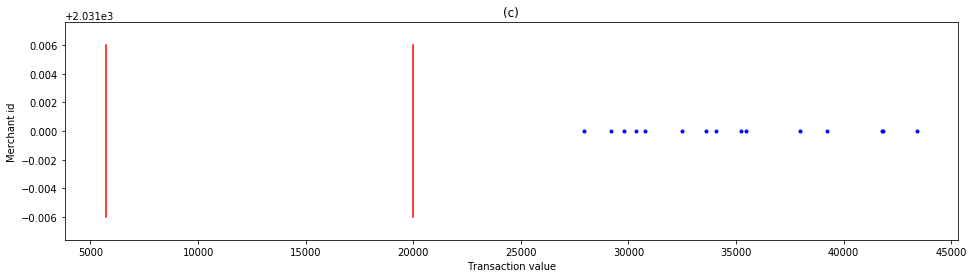

In [15]:
# Look for patterns in merchant data
plt.rcParams['figure.figsize'] = (16,4)

# Plot merchant id vs transaction value for the first 50 transactions
mt1 = plt.subplot(1,2,1)
mt1.scatter(train_data['merchant_id'].loc[0:50], train_data['transaction_value'].loc[0:50], c='b', marker='.')
mt1.set(xlabel="Merchant id",ylabel="Transaction value")
mt1.set_title("(a)")

# Plot merchant id vs transaction value for all transactions
mt2 = plt.subplot(1,2,2)
mt2.scatter(train_data['merchant_id'], train_data['transaction_value'], c='b', marker='.')
mt2.set(xlabel="Merchant id",ylabel="Transaction value")
mt2.set_title("(b)")
plt.show()

# Plot all transaction values for a single merchant
plt.scatter(train_data[train_data['merchant_id']==train_data['merchant_id'].loc[6]].transaction_value, train_data[train_data['merchant_id']==train_data['merchant_id'].loc[6]].merchant_id, c='b', marker='.')
plt.plot([5700, 5700], [2030.994, 2031.006], 'r') #Separator between low and middle price band
plt.plot([20000, 20000], [2030.994, 2031.006], 'r') #Separator between middle and high price band
plt.title("(c)")
plt.xlabel("Transaction value")
plt.ylabel("Merchant id")
plt.show()

It is clear from (a) and (b) that the merchant ids are unordered, making it difficult to visualise trends without further processing. However, having separated out a single merchant in (c), it is worth noting that all of their transactions are in the high price band. How often is this the case?

In [17]:
# Find out how many merchants make all of their transactions in a single price band
count_merchants = 0
count_single_band_merchants = 0
for m in np.unique(train_data['merchant_id']): #unique merchant ids
    count_merchants +=1
    
    # Count the number of transactions in each band made by this merchant
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['merchant_id']==m].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
            
    # If two counts are 0, the merchant makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if all_low or all_mid or all_high:
        count_single_band_merchants +=1

print('Number of merchants:', count_merchants)
print('Number of merchants making all transactions in a single band:', count_single_band_merchants)
print('Proportion in a single band:', 100 * count_single_band_merchants / count_merchants)

Number of merchants: 5000
Number of merchants making all transactions in a single band: 4810
Proportion in a single band: 96.2


That proportion is quite high. Obviously it alone is not sufficient to determine whether a transaction is fraudulent but I might look at the merchant behaviour for fraudulent transactions and see if this is a predictor.

It seems worth testing whether there is a similar trend for clients.

<h3>Looking for patterns in client behaviour</h3>

In [31]:
# Find out how many clients make all of their transactions in a single price band
count_clients = 0
count_single_band_clients = 0
for m in np.unique(train_data['client_id']): #unique client ids
    count_clients +=1
    
    # Count the number of transactions in each band made by this client
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['client_id']==m].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
            
    # If two counts are 0, the client makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if all_low or all_mid or all_high:
        count_single_band_clients +=1

print('Number of clients:', count_clients)
print('Number of clients making all transactions in a single band:', count_single_band_clients)
print('Proportion in a single band:', str(100 * count_single_band_clients / count_clients)+'%')

Number of clients: 498
Number of clients making all transactions in a single band: 486
Proportion in a single band: 97.59036144578313%


Again, this is clearly not sufficient to provide 10 fraudulent transactions. However, is there a correlation between the client making a transaction outside of their normal band and the transaction being fraudulent?

In [73]:
# Find out how many multiband clients have fraudulent transactions
band_names = ['low', 'mid', 'high']
count_multiband_clients = 0
count_multiband_fraud_clients = 0
count_out_of_band_fraud = 0
count_expensive_fraud = 0
count_cheap_fraud = 0
for m in np.unique(train_data['client_id']): #unique client ids
    # Count the number of transactions in each band made by this client
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['client_id']==m].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
            
    # If two counts are 0, the client makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if not (all_low or all_mid or all_high):
        # This client has transactions in multiple bands
        count_multiband_clients += 1
        
        # Look for patterns in band counts
        print('\nClient:', m)
        print('Low band:', count_low)
        print('Middle band:', count_mid)
        print('High band:', count_high)
        
        # Check if the client has a fraudulent transaction
        client_data = train_data[train_data['client_id']==m]
        if 1 in list(client_data.fraud_flag):
            count_multiband_fraud_clients += 1
            print("There was a fraudulent transaction for this client")
        else:
            continue
        
        # Find the band that the fraudulent transaction is in
        fraud_amount = list(client_data[client_data['fraud_flag']==1].transaction_value)[0]
        if fraud_amount > 20000:
            fraud_band = 'high'
        elif fraud_amount < 5700:
            fraud_band = 'low'
        else:
            fraud_band = 'mid'
        
        # Find out if the fraudulent transaction is in a different band to most transactions
        max_band = band_names[np.argmax([count_low, count_mid, count_high])]
        
        if fraud_band != max_band:
            count_out_of_band_fraud += 1
            
            # Count how many fraudulent transactions are in a higher band than most of the client's transactions
            if fraud_band == 'high':
                count_expensive_fraud += 1
            elif fraud_band == 'mid' and max_band == 'low':
                count_expensive_fraud += 1
                
            # Count how many fraudulent transactions are in a lower band than most of the client's transactions
            if fraud_band == 'low':
                count_cheap_fraud += 1
            elif fraud_band == 'mid' and max_band == 'high':
                count_cheap_fraud += 1
        

print('\nNumber of multiband clients:', count_multiband_clients)
print('Number of multiband clients with fraudulent transactions:', count_multiband_fraud_clients)
print('Proportion of fraudulent transactions found:', str(100*count_multiband_fraud_clients/10)+'%')
print("Proportion of fraudulent transactions found outside of the client's normal band:", str(100*count_out_of_band_fraud/10)+'%')
print("Proportion of fraudulent transactions found in a higher band than the normal client's band", str(100*count_expensive_fraud/10)+'%')
print("Proportion of fraudulent transactions found in a lower band than the normal client's band", str(100*count_cheap_fraud/10)+'%')


Client: 47
Low band: 85
Middle band: 1
High band: 0
There was a fraudulent transaction for this client

Client: 52
Low band: 0
Middle band: 1
High band: 77
There was a fraudulent transaction for this client

Client: 120
Low band: 0
Middle band: 1
High band: 184
There was a fraudulent transaction for this client

Client: 171
Low band: 0
Middle band: 1
High band: 283
There was a fraudulent transaction for this client

Client: 175
Low band: 258
Middle band: 1
High band: 0
There was a fraudulent transaction for this client

Client: 191
Low band: 1
Middle band: 296
High band: 0
There was a fraudulent transaction for this client

Client: 248
Low band: 1
Middle band: 351
High band: 0
There was a fraudulent transaction for this client

Client: 263
Low band: 0
Middle band: 1
High band: 359
There was a fraudulent transaction for this client

Client: 264
Low band: 1
Middle band: 398
High band: 0

Client: 269
Low band: 0
Middle band: 1
High band: 381

Client: 357
Low band: 211
Middle band: 0
High

That seems quite conclusive. Obviously this still can't be used to predict whether a transaction is fraudulent without further work but it will definitely be useful as a filter.

<h3>Looking for temporal patterns</h3>

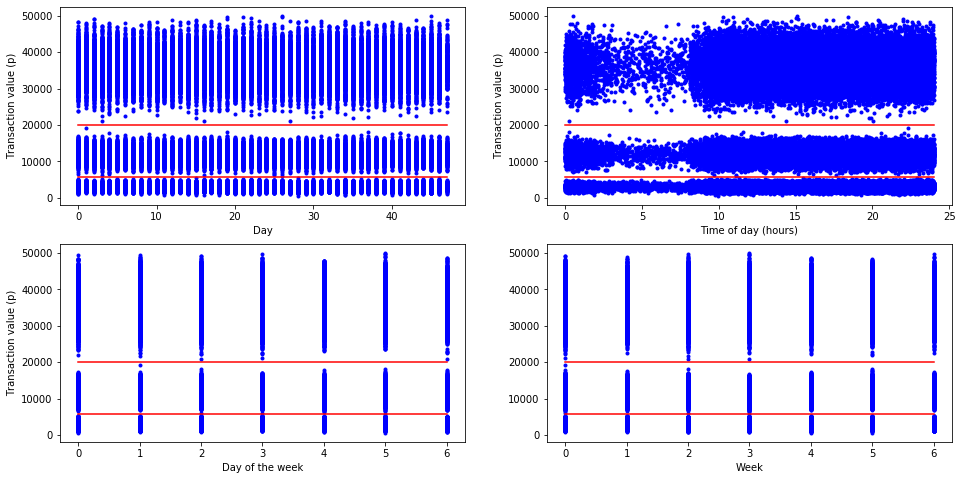

In [19]:
# Look at patterns over different time scales
plt.rcParams['figure.figsize'] = (16,8)

# Each day that data was taken
dt = plt.subplot(2,2,1)
dt.scatter(train_data['date'], train_data['transaction_value'], c='b', marker='.')
dt.plot([0,47], [5700, 5700], 'r')
dt.plot([0,47], [20000, 20000], 'r')
dt.set_xlabel('Day')
dt.set_ylabel('Transaction value (p)')

# Time of day
tt = plt.subplot(2,2,2)
tt.scatter(train_data['time']/3600, train_data['transaction_value'], c='b', marker='.')
tt.plot([0,24], [5700, 5700], 'r')
tt.plot([0,24], [20000, 20000], 'r')
tt.set_xlabel('Time of day (hours)')
tt.set_ylabel('Transaction value (p)')

# Day of the week
dwt = plt.subplot(2,2,3)
dwt.scatter(train_data['date']%7, train_data['transaction_value'], c='b', marker='.')
dwt.plot([0,6], [5700, 5700], 'r')
dwt.plot([0,6], [20000, 20000], 'r')
dwt.set_xlabel('Day of the week')
dwt.set_ylabel('Transaction value (p)')

# Week
wt = plt.subplot(2,2,4)
wt.scatter((train_data['date']/7).astype(int), train_data['transaction_value'], c='b', marker='.') #Note: converting to integer automatically rounds down
wt.plot([0,6], [5700, 5700], 'r')
wt.plot([0,6], [20000, 20000], 'r')
wt.set_xlabel('Week')
wt.set_label('Transaction value (p)')
plt.show()

At a macro level (where micro would look at specific clients or merchants), there doesn't seem to be a correlation between time and transaction value.

The only visible feature is the drop in transaction rate between 2am and 7am.

Also, the transaction with a value just below £200 seems out of place. This could be because it is fraudulent.

In [20]:
lowmid_price_band_data = train_data[train_data['transaction_value'] < 20000]
print(max(lowmid_price_band_data['transaction_value']))
print(train_data[train_data['transaction_value'] == max(lowmid_price_band_data['transaction_value'])])

19289
      transaction_id  client_id  transaction_value  merchant_id  date   time  \
3998            3999        269              19289         3939     1  80334   

      fraud_flag  
3998           0  


From the fraud flag, this transaction isn't fraudulent. However, this is a good reminder that unusual payments are not necessarily fraudulent.

<h3>Looking for patterns using principle component analysis (PCA)</h3>

In [52]:
# Use one-hot encoding to enable PCA on the train data
#   i.e. turn the multivalued columns 'client_id' and 'merchant_id' into many binary-encoded columns
enc_train_data = pd.get_dummies(train_data, columns=['merchant_id', 'client_id'], sparse=True) # Sparse should make data storage more efficient

# This is left as an illustration of the change to datafram structure and indexing
print(train_data[train_data['merchant_id']==0])
print(enc_train_data[enc_train_data['merchant_id_0']==1])

       transaction_id  client_id  transaction_value  merchant_id  date   time  \
865               866         96               2971            0     0  52117   
7340             7341        204               3103            0     3  56051   
11000           11001        262               2125            0     5  39872   
13034           13035        274               3749            0     6  37274   
14292           14293        283               3775            0     6  71962   
25570           25571        308               2241            0    12  33837   
27647           27648        135               4030            0    13  33234   
27664           27665        369               2345            0    13  33676   
46784           46785        262               4113            0    22  36041   
49866           49867         82               3383            0    23  62994   
60627           60628        128               2823            0    28  68285   
70606           70607       

In [53]:
def client_PCA(data, client_id, n_components=2, whiten=True):
    """Take data on transactions made by a single client and run principle component analysis on it."""
    
    # Gather data for the requested client and remove unnecessary columns
    client_data_columns = list(data.columns.values)[1:4]
    client_data = data[data['client_id_'+str(client_id)]==1]
    client_data = client_data[client_data_columns]
    
    # Run the PCA on the reduced data
    pca = PCA(n_components=n_components, whiten=whiten)
    pca_data = pca.fit_transform(client_data)

    return pca_data

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
33263           33264        496              21794         3701    15  71159   

       fraud_flag  
33263           1  


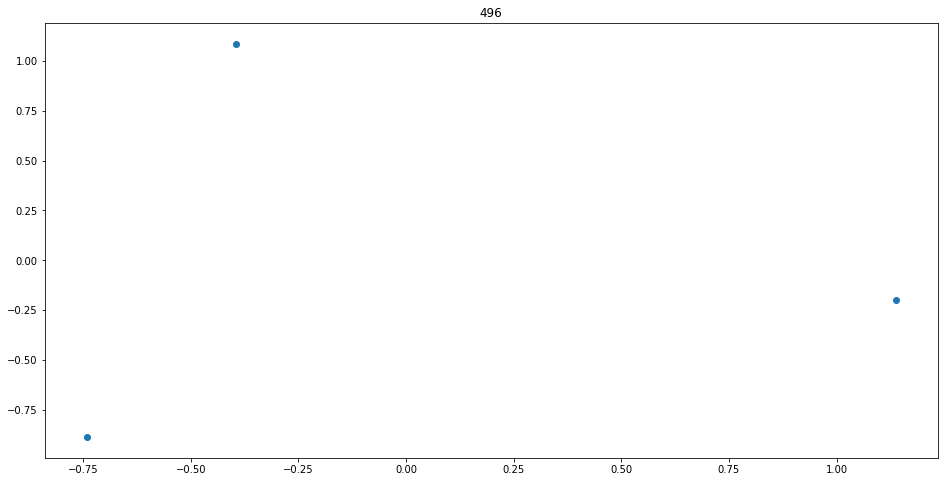

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
34542           34543        357              34236         4051    16  47773   

       fraud_flag  
34542           1  


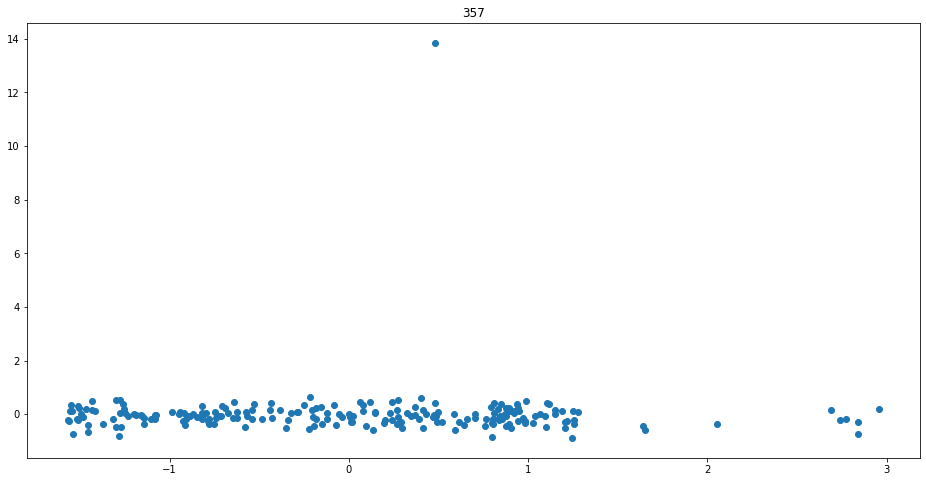

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
34739           34740        263              12931         2059    16  53092   

       fraud_flag  
34739           1  


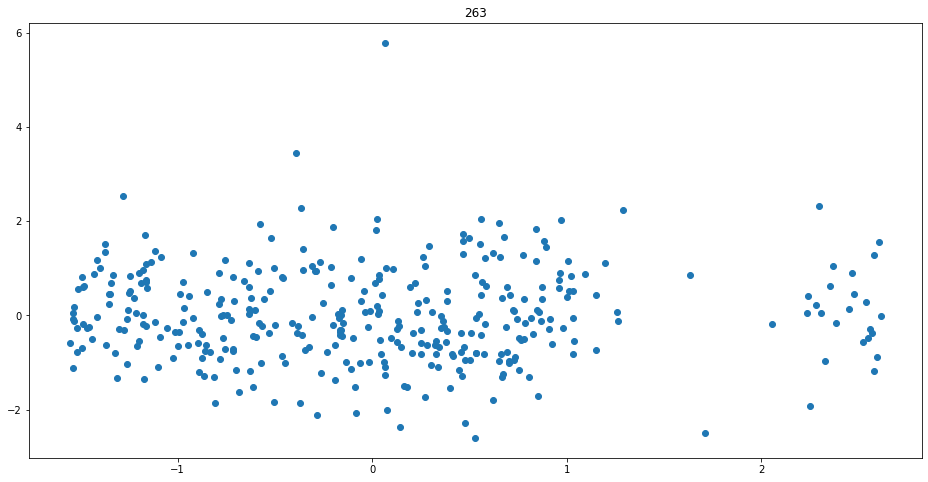

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
39107           39108        191               1887         4069    18  57040   

       fraud_flag  
39107           1  


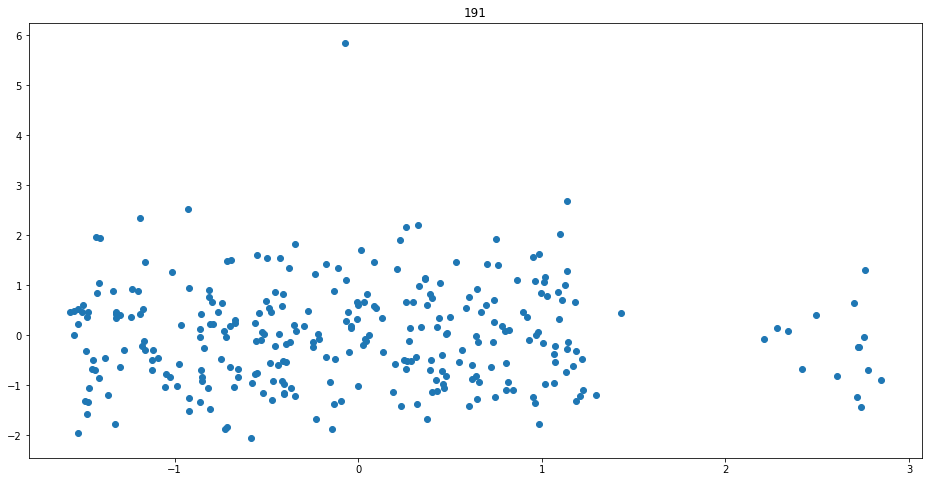

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
40666           40667        175              18038          431    19  41588   

       fraud_flag  
40666           1  


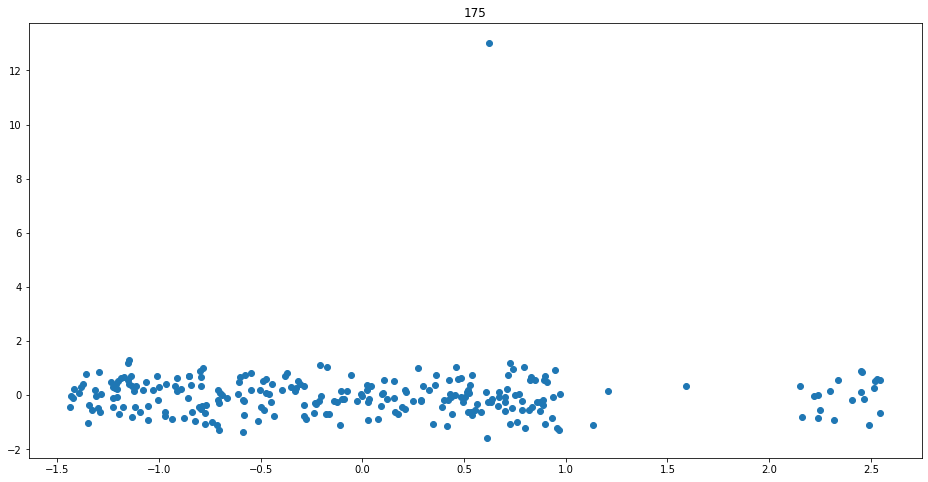

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
42282           42283        171               7380         4581    19  85927   

       fraud_flag  
42282           1  


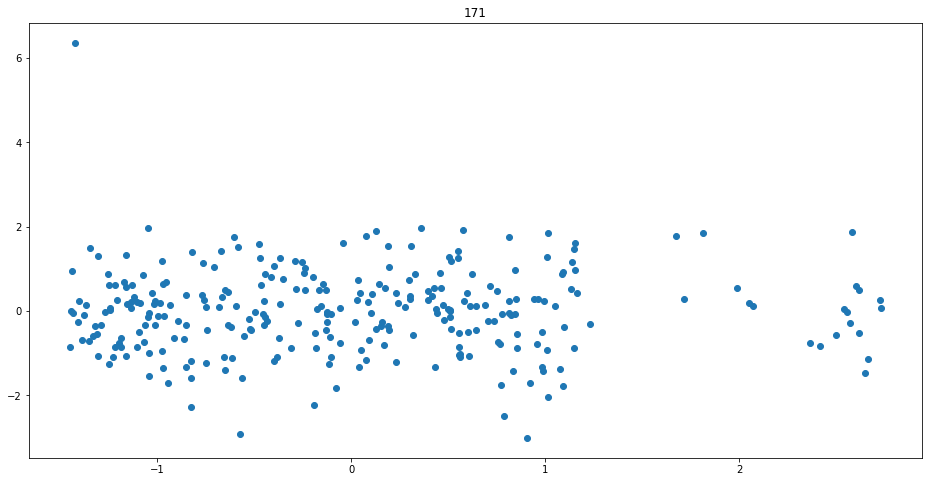

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
48475           48476         47              12423         2817    22  82763   

       fraud_flag  
48475           1  


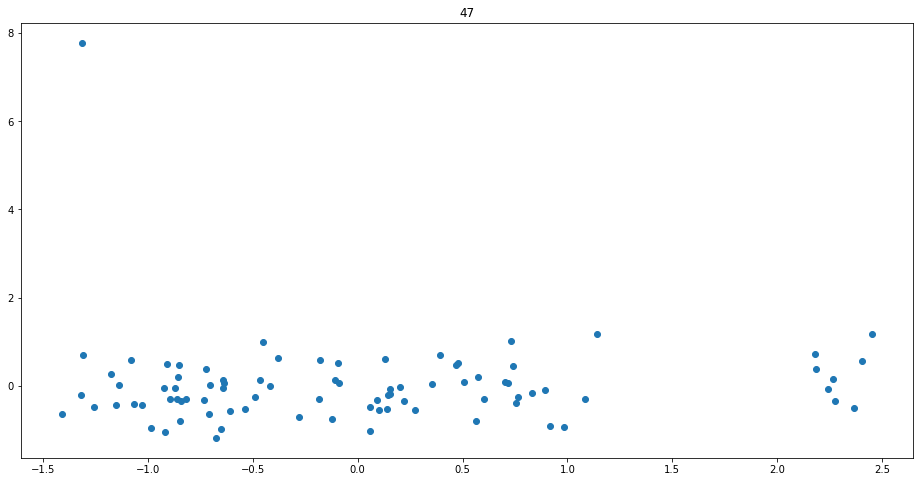

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
51557           51558        120               8186          865    24  51472   

       fraud_flag  
51557           1  


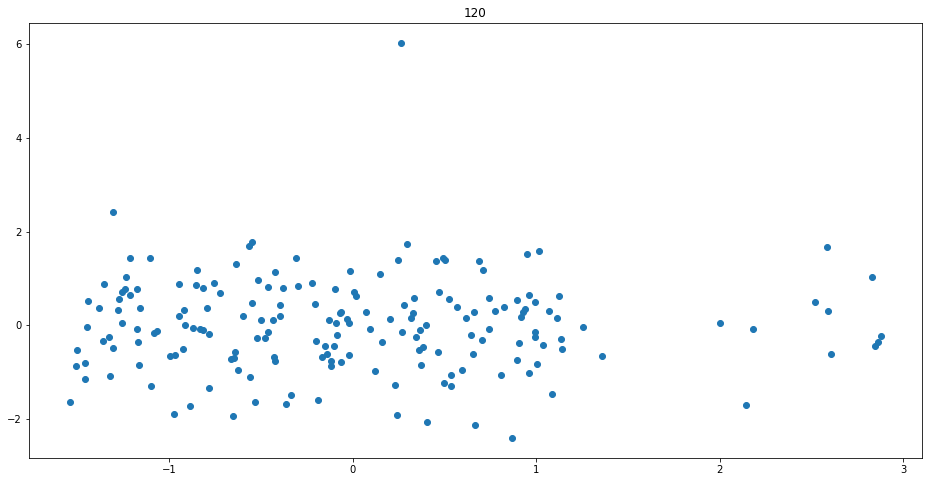

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
53167           53168        248               1671          282    25  37416   

       fraud_flag  
53167           1  


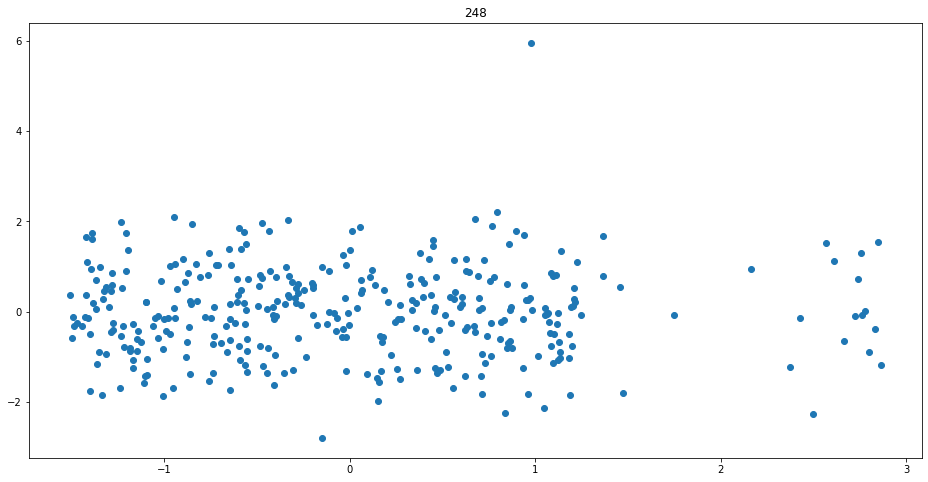

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
67227           67228         52              10656          477    31  75126   

       fraud_flag  
67227           1  


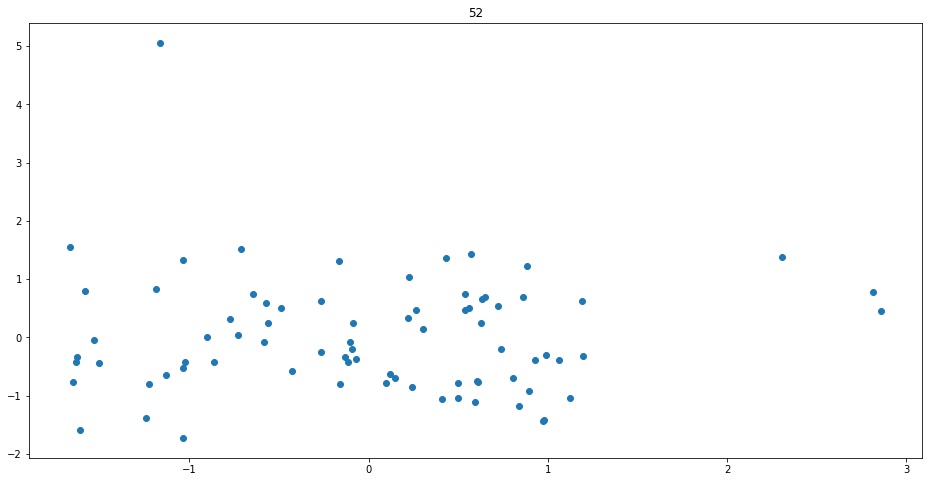

In [65]:
for client_id in train_data[train_data['fraud_flag']==1].client_id:
    # Run PCA for that client
    pca_data = client_PCA(enc_train_data, client_id)
    
    # Find out whether the outlier is actually the fraudulent transaction
    outlier_index = np.argmax(pca_data[:,1])
    outlier_transaction_id = list(enc_train_data[enc_train_data['client_id_'+str(client_id)]==1].transaction_id)[outlier_index]
    print(train_data[train_data['transaction_id']==outlier_transaction_id])
    
    # Plot the PCA data
    plt.scatter(pca_data[:,0], pca_data[:,1])
    plt.title(str(client_id))
    plt.show()

For each of the clients with fraudulent transactions, there seems to be one clear outlier transaction. Since it always has the largest y value in the PCA data, I have used that to isolate it.

For each client with a fraudulent transaction, this method has correctly identified the fraudulent transaction. However, I would like to know what other clients' data show after PCA processing.

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()
C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
15686           15687          0               3214         2629     7  51502   

       fraud_flag  
15686           0  


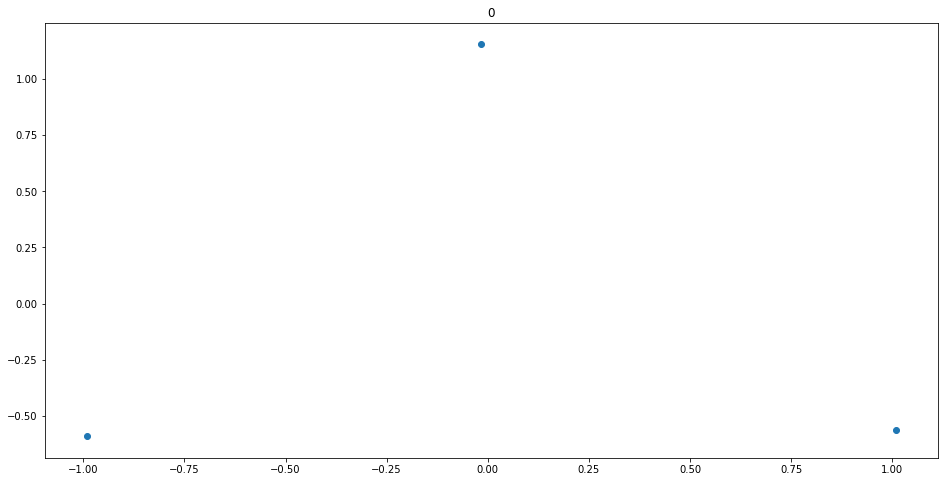

Client 1 does not have enough transactions to check.


C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
83715           83716          2              33912         4353    39  63418   

       fraud_flag  
83715           0  


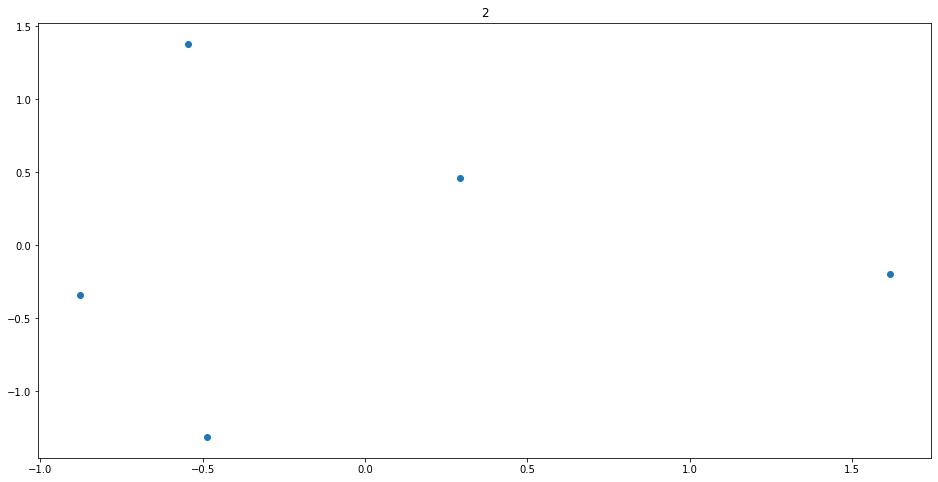

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
49718           49719          3              10291          321    23  58925   

       fraud_flag  
49718           0  


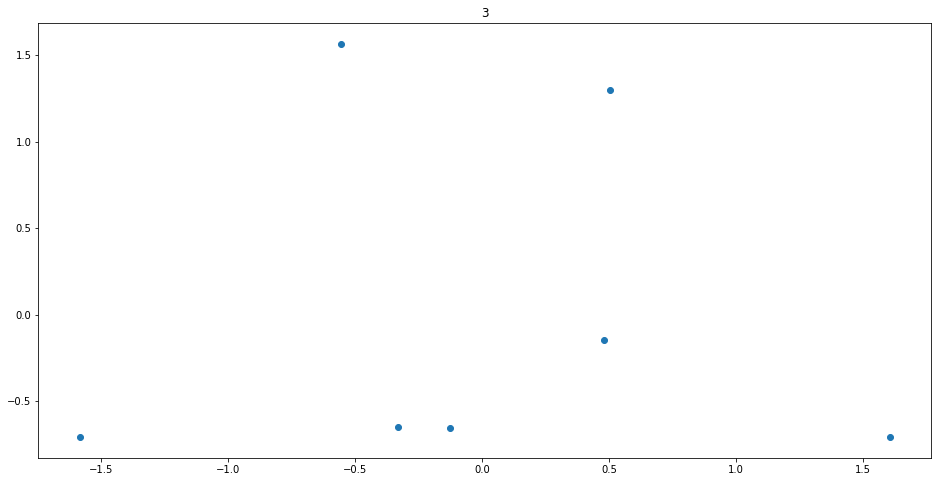

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
29450           29451          4              15303         1172    13  82645   

       fraud_flag  
29450           0  


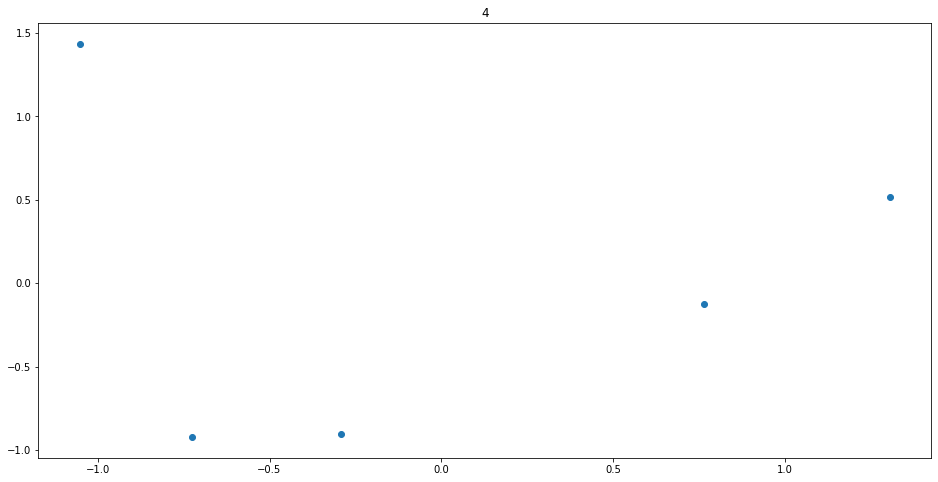

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
64770           64771          5               1930         2060    30  65515   

       fraud_flag  
64770           0  


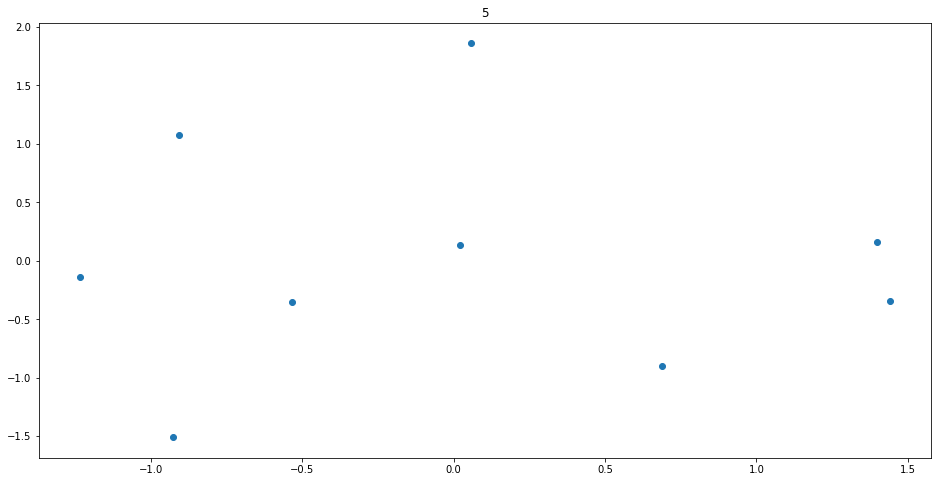

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


      transaction_id  client_id  transaction_value  merchant_id  date   time  \
5198            5199          6              14486          359     2  55525   

      fraud_flag  
5198           0  


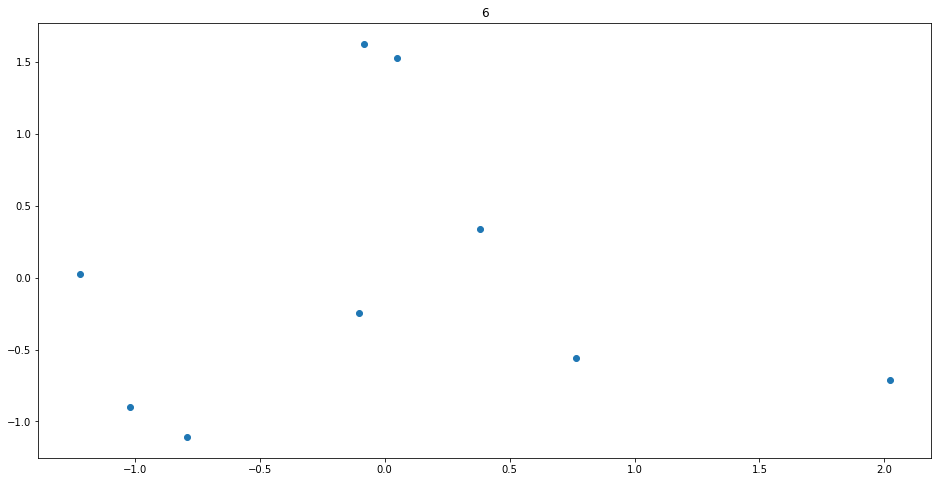

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


      transaction_id  client_id  transaction_value  merchant_id  date   time  \
9336            9337          7              15057         1968     4  52678   

      fraud_flag  
9336           0  


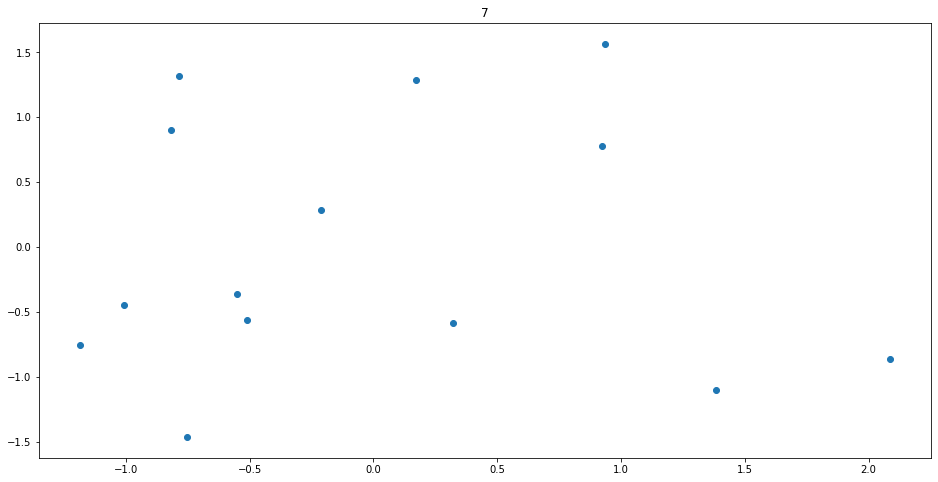

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
25520           25521          8               8075          239    12  32274   

       fraud_flag  
25520           0  


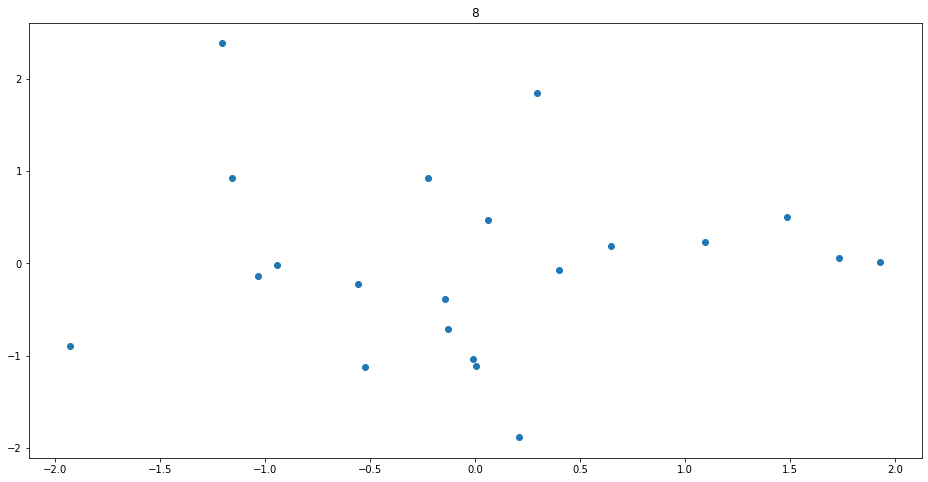

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
21369           21370          9              44929         2149    10  33829   

       fraud_flag  
21369           0  


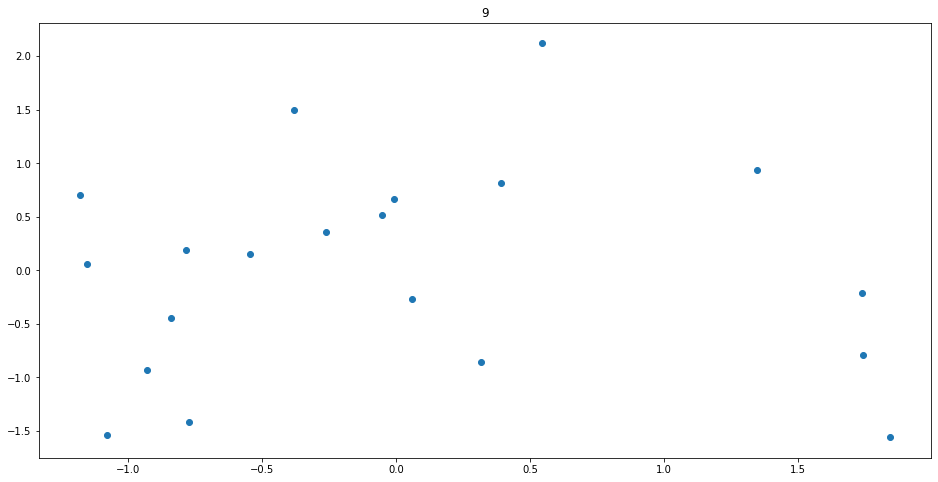

In [68]:
for client_id in range(0, 10):
    # Check that there are enough transactions to run PCA on (there need to be more samples than n_components=2)
    if len(list(enc_train_data[enc_train_data['client_id_'+str(client_id)]==1].transaction_id)) <= 2:
        print("Client", client_id, "does not have enough transactions to check.")
        continue

    # Run PCA for that client
    pca_data = client_PCA(enc_train_data, client_id)

    # Find out whether the outlier is actually the fraudulent transaction
    outlier_index = np.argmax(pca_data[:,1])
    outlier_transaction_id = list(enc_train_data[enc_train_data['client_id_'+str(client_id)]==1].transaction_id)[outlier_index]
    print(train_data[train_data['transaction_id']==outlier_transaction_id])

    # Plot the PCA data
    plt.scatter(pca_data[:,0], pca_data[:,1])
    plt.title(str(client_id))
    plt.show()

For the most part, the scatter plots look very different. With y-values on fraudulent valuent reaching as high as 14 but generally reaching 5 or 6, whereas they generally stay below 2.5 for non-fraudulent transactions.

The only cases where the difference is less clear are those with very few (~3) transactions. At this point there doesn't seem to be enough data for the PCA to do anything more than create a triangle with large separation between all three points. For the training data, though, all clients with only 3 transactions would filtered out before the PCA stage because they do not have transactions in multiple bands. The only exception is client 496 who had two transactions in the low proce band and one in the high price band. I think that this behaviour should be flagged as fraud by common sense.

With these two methods proving so effective, I will create a function that analyses the price bands to filter clients then uses PCA to identify fraudulent transactions.

<h3>Testing my final method against the training data</h3>

In [88]:
def find_fraudulent_transactions(data, n_components=2, whiten=True):
    # Find a list of multiband clients, filtering out all others
    multiband_client_list = []
    count_multiband_clients = 0
    for m in np.unique(data['client_id']): #unique client ids
        # Count the number of transactions in each band made by this client
        count_low = 0
        count_mid = 0
        count_high = 0
        for t in data[data['client_id']==m].transaction_value:
            if t > 20000:
                count_high+=1
            elif t < 5700:
                count_low+=1
            else:
                count_mid+=1
                
        # If two counts are 0, the client makes all transactions in a single band
        all_high = (count_mid==0) and (count_low==0)
        all_mid = (count_high==0) and (count_low==0)
        all_low = (count_mid==0) and (count_high==0)
        if not (all_low or all_mid or all_high):
            # This client has transactions in multiple bands
            multiband_client_list.append(m)
            count_multiband_clients += 1

            # Print band counts to look for obviously unusual behaviour
            print('\nClient:', m)
            print('Low band:', count_low)
            print('Middle band:', count_mid)
            print('High band:', count_high)

    print('\nNumber of multiband clients:', count_multiband_clients)
    
    # Use one-hot encoding to enable PCA on the train data
    enc_data = pd.get_dummies(data, columns=['merchant_id', 'client_id'], sparse=True)
    
    # Loop through the filtered list of clients to find the most likely transaction to be fraudulent for each client
    for client_id in multiband_client_list:
        # Check that there are enough transactions to run PCA on (there need to be more samples than n_components=2)
        if len(list(enc_data[enc_data['client_id_'+str(client_id)]==1].transaction_id)) <= n_components:
            print("Client", client_id, "does not have enough transactions to check.")
            continue

        # Run PCA for that client
        pca_data = client_PCA(enc_data, client_id)

        # Give all available information about the supposedly fraudulent transaction
        outlier_index = np.argmax(pca_data[:,1])
        outlier_transaction_id = list(enc_data[enc_data['client_id_'+str(client_id)]==1].transaction_id)[outlier_index]
        print(data[data['transaction_id']==outlier_transaction_id])

        # Plot the PCA data so that clients most likely to have fraudulent transactions can be found by eye
        plt.scatter(pca_data[:,0], pca_data[:,1])
        plt.title(str(client_id))
        plt.show()


Client: 47
Low band: 85
Middle band: 1
High band: 0

Client: 52
Low band: 0
Middle band: 1
High band: 77

Client: 120
Low band: 0
Middle band: 1
High band: 184

Client: 171
Low band: 0
Middle band: 1
High band: 283

Client: 175
Low band: 258
Middle band: 1
High band: 0

Client: 191
Low band: 1
Middle band: 296
High band: 0

Client: 248
Low band: 1
Middle band: 351
High band: 0

Client: 263
Low band: 0
Middle band: 1
High band: 359

Client: 264
Low band: 1
Middle band: 398
High band: 0

Client: 269
Low band: 0
Middle band: 1
High band: 381

Client: 357
Low band: 211
Middle band: 0
High band: 1

Client: 496
Low band: 2
Middle band: 0
High band: 1

Number of multiband clients: 12


C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
48475           48476         47              12423         2817    22  82763   

       fraud_flag  
48475           1  


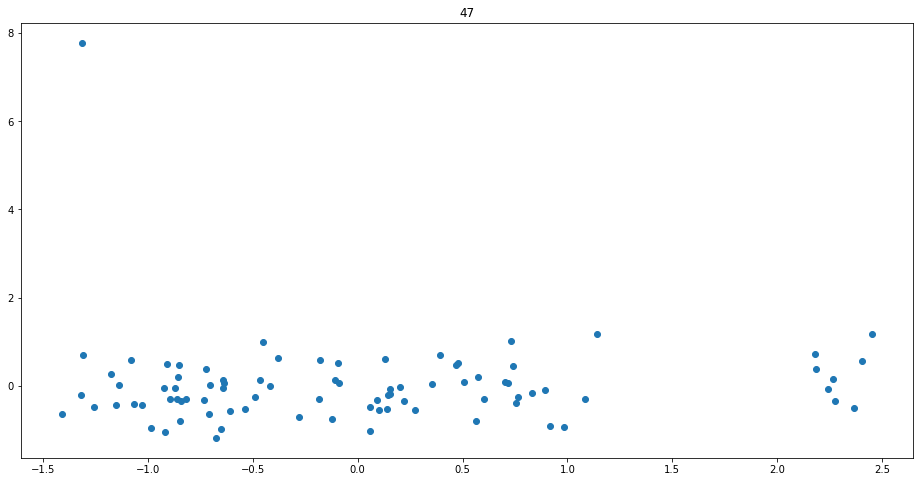

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
67227           67228         52              10656          477    31  75126   

       fraud_flag  
67227           1  


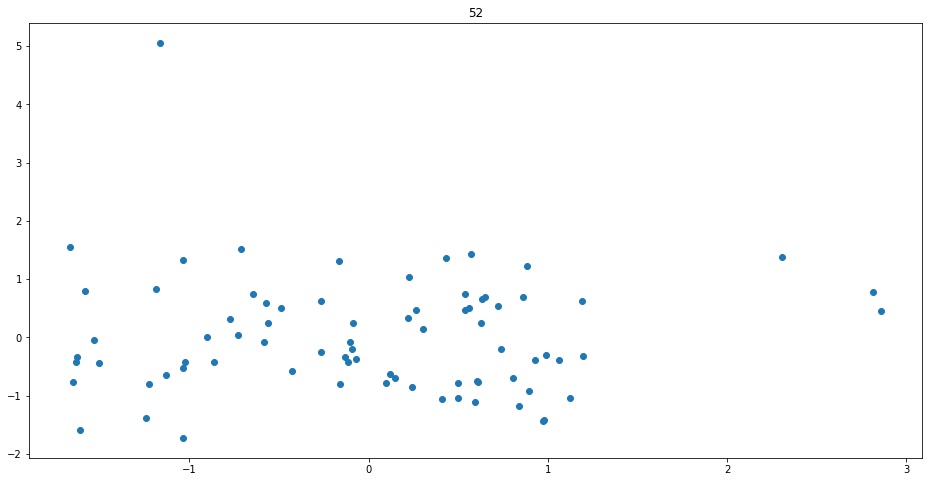

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
51557           51558        120               8186          865    24  51472   

       fraud_flag  
51557           1  


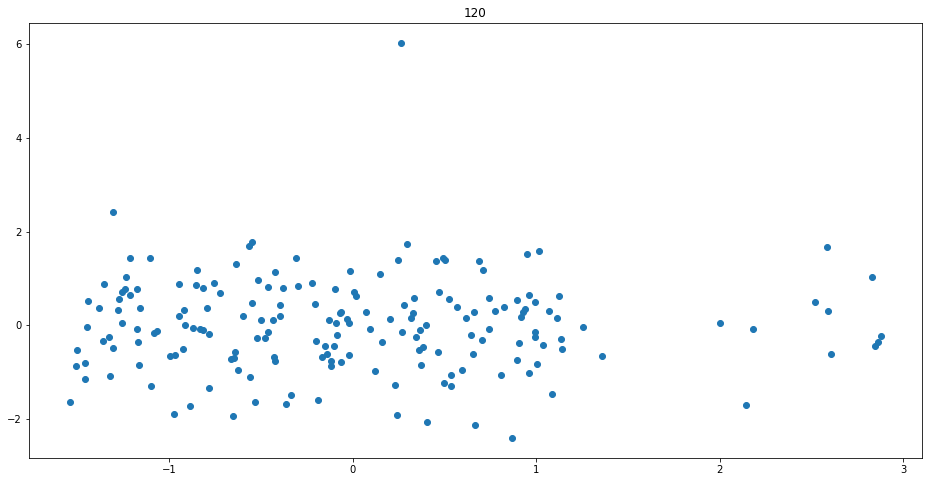

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
42282           42283        171               7380         4581    19  85927   

       fraud_flag  
42282           1  


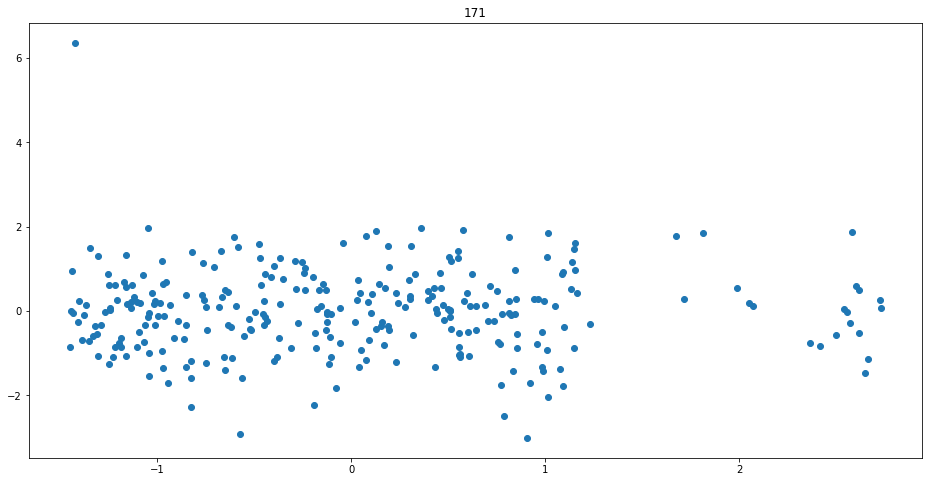

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
40666           40667        175              18038          431    19  41588   

       fraud_flag  
40666           1  


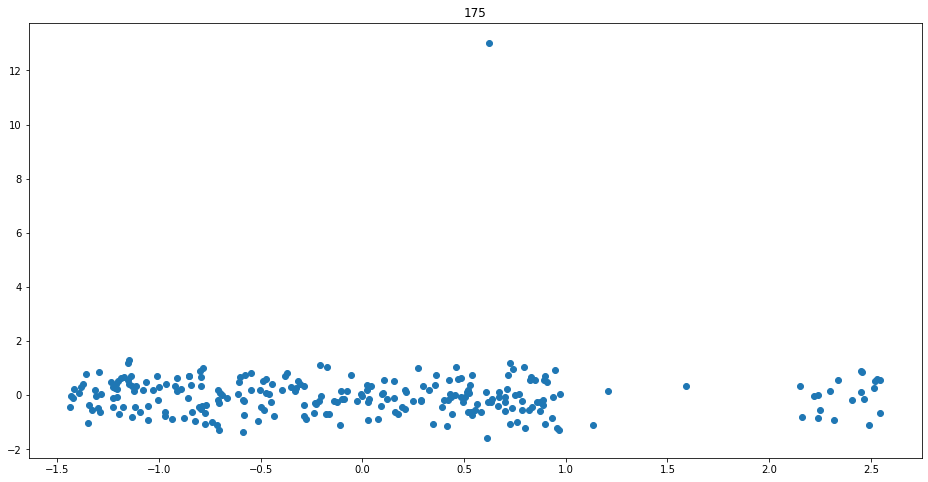

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
39107           39108        191               1887         4069    18  57040   

       fraud_flag  
39107           1  


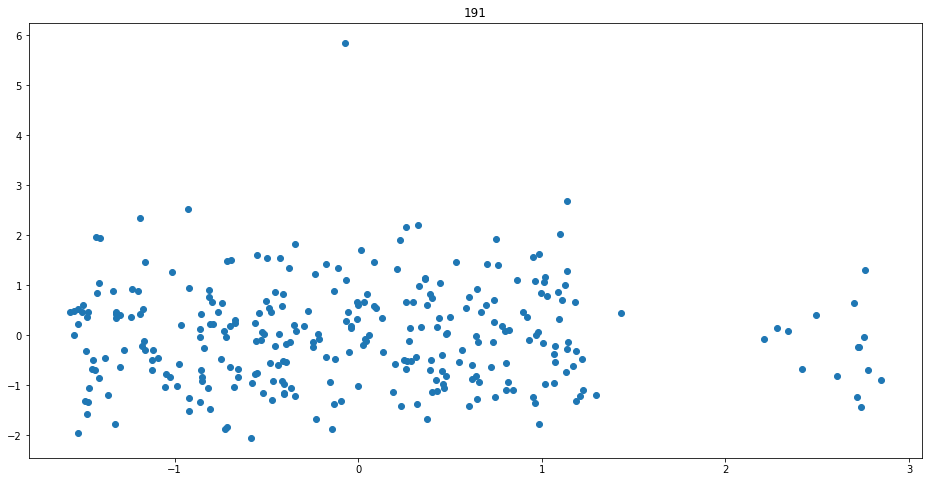

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
53167           53168        248               1671          282    25  37416   

       fraud_flag  
53167           1  


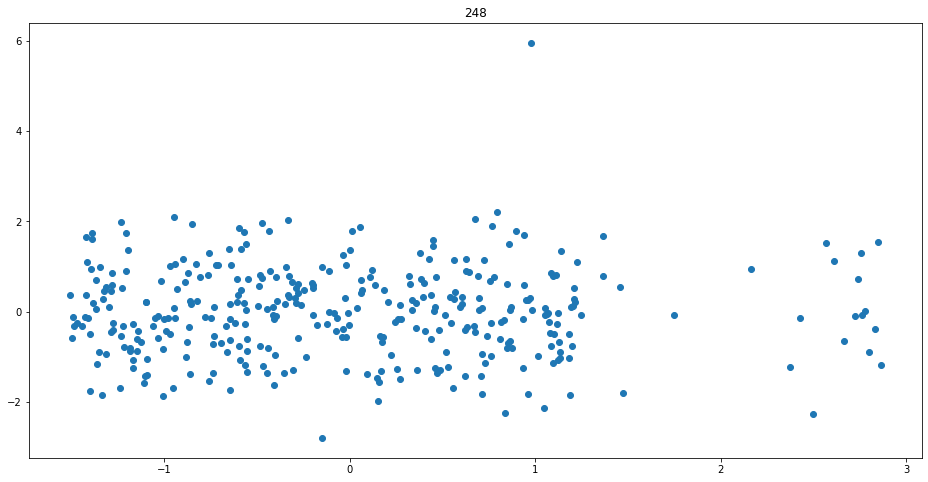

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
34739           34740        263              12931         2059    16  53092   

       fraud_flag  
34739           1  


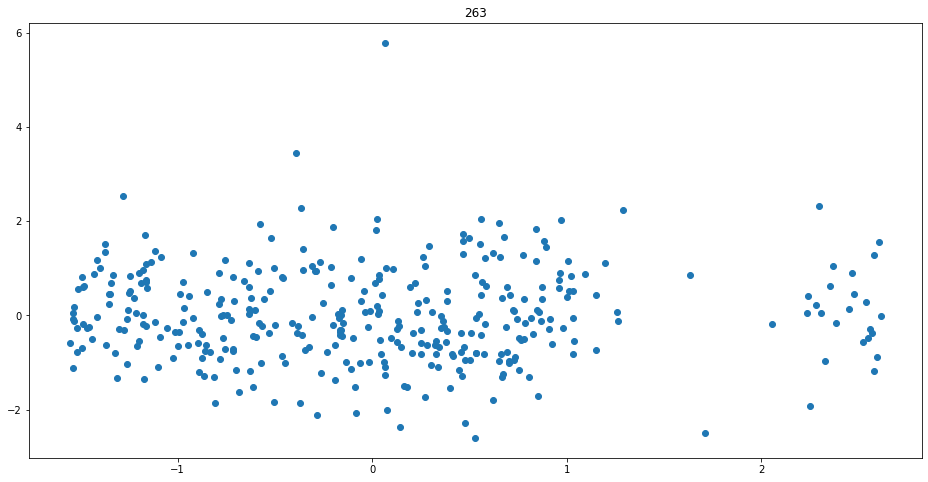

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
99188           99189        264               5344         4825    46  82537   

       fraud_flag  
99188           0  


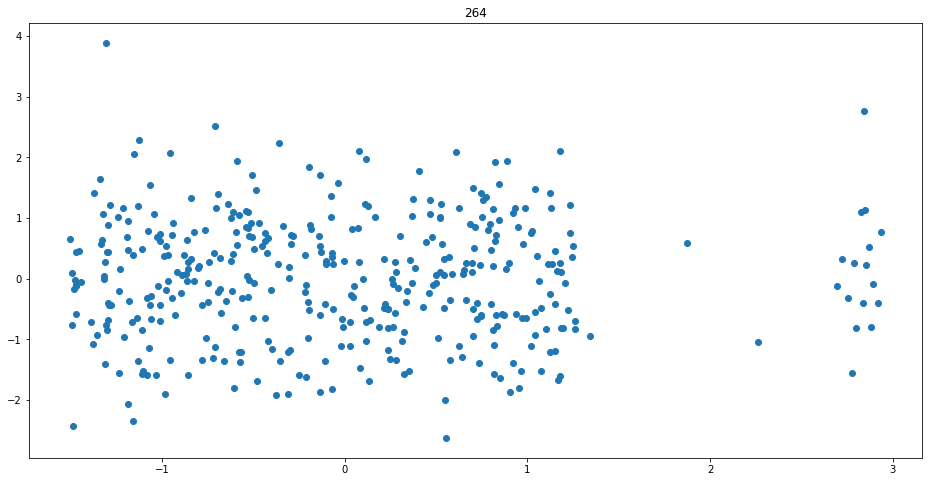

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


      transaction_id  client_id  transaction_value  merchant_id  date   time  \
3998            3999        269              19289         3939     1  80334   

      fraud_flag  
3998           0  


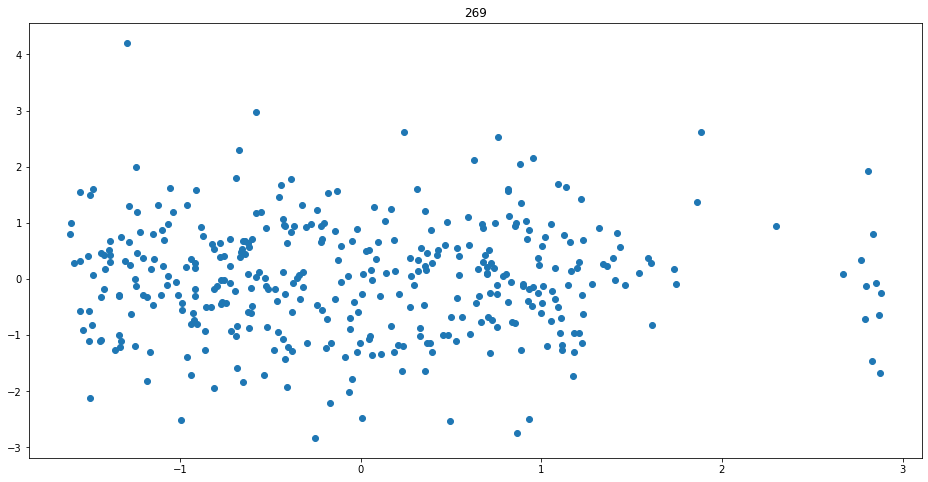

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
34542           34543        357              34236         4051    16  47773   

       fraud_flag  
34542           1  


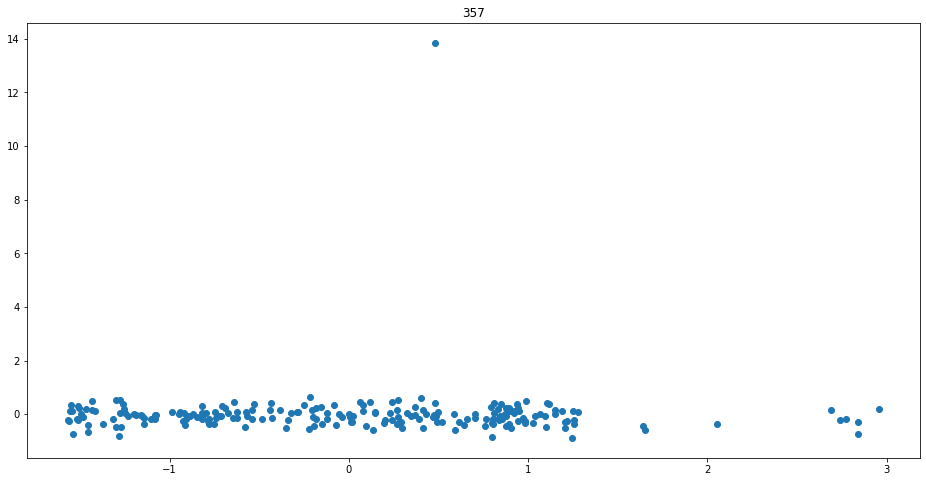

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
33263           33264        496              21794         3701    15  71159   

       fraud_flag  
33263           1  


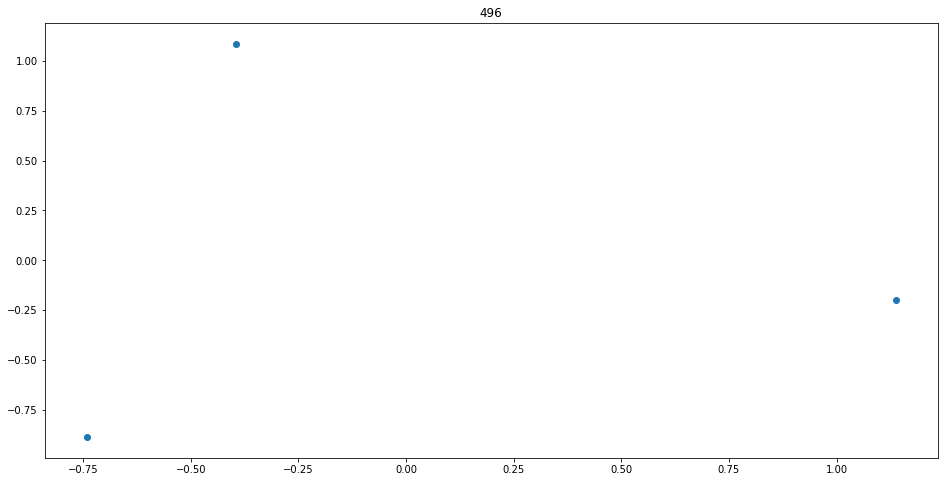

In [75]:
find_fraudulent_transactions(train_data)

Although this isn't as definitive as I might like, the two transactions without a fraud flag (client_ids 264 and 269) have y_values close to 4 whereas two similar clients (client_ids 248 and 263) have values close to 6 with a larger visual gap. I feel confident that my 10 best guesses from the information gained above would be the 10 fraudulent transactions.

With a reasonable method set up, I will run this same process on the test data.

<h3>Using my final method to find fraudulent transactions in the test data</h3>

In [83]:
test_data = pd.read_csv('transaction_two_base.csv', names=train_data_cols)
test_data.shape

(100000, 7)

In [86]:
test_data #[test_data['fraud_flag']==1]

,transaction_id,client_id,transaction_value,merchant_id,date,time,fraud_flag
0,1,108,3130,3276,0,9,0
1,2,217,12716,1614,0,51,0
2,3,354,2655,3994,0,104,0
3,4,285,9286,1827,0,150,0
4,5,24,11334,3878,0,196,0
...,...,...,...,...,...,...,...
99995,99996,195,33632,451,47,50220,0
99996,99997,75,34280,2940,47,50245,0
99997,99998,234,3203,3308,47,50263,0
99998,99999,51,36803,1525,47,50287,0


Note: The test data includes a column for the fraud flag but all values are 0


Client: 11
Low band: 24
Middle band: 0
High band: 1

Client: 28
Low band: 1
Middle band: 1
High band: 44

Client: 93
Low band: 123
Middle band: 1
High band: 0

Client: 131
Low band: 0
Middle band: 1
High band: 232

Client: 247
Low band: 0
Middle band: 1
High band: 383

Client: 266
Low band: 1
Middle band: 395
High band: 0

Client: 325
Low band: 0
Middle band: 281
High band: 1

Client: 385
Low band: 0
Middle band: 1
High band: 179

Client: 412
Low band: 1
Middle band: 130
High band: 0

Client: 414
Low band: 124
Middle band: 0
High band: 1

Number of multiband clients: 10


C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
19413           19414         11              22473         2408     9  41357   

       fraud_flag  
19413           0  


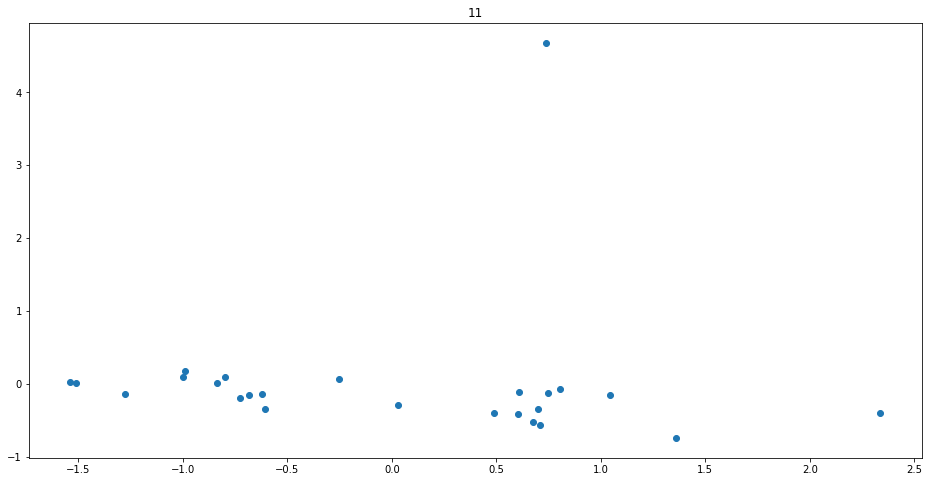

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
88057           88058         28               1358          895    41  70686   

       fraud_flag  
88057           0  


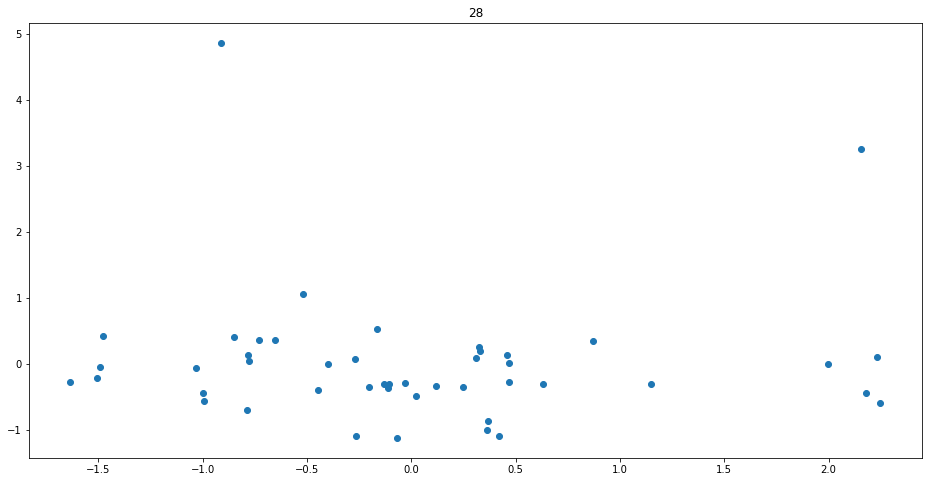

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
79659           79660         93              16481         3064    37  71817   

       fraud_flag  
79659           0  


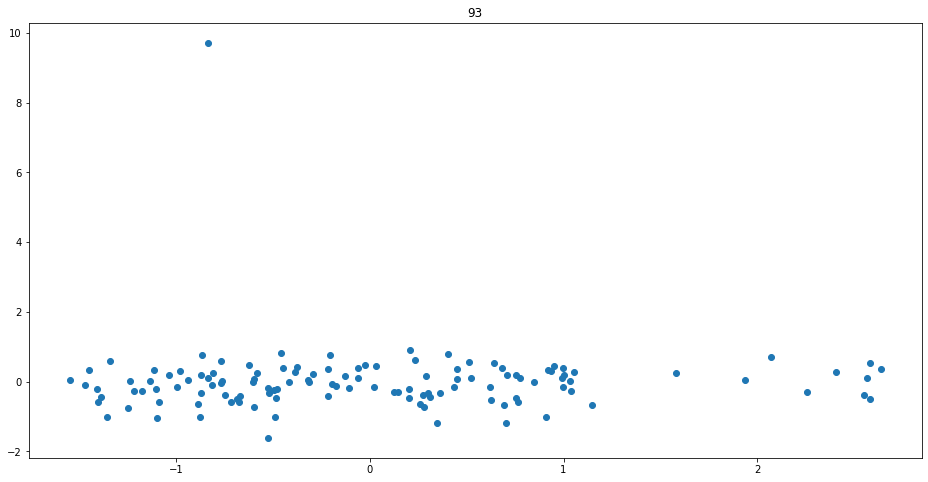

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
21604           21605        131              11877          614    10  43648   

       fraud_flag  
21604           0  


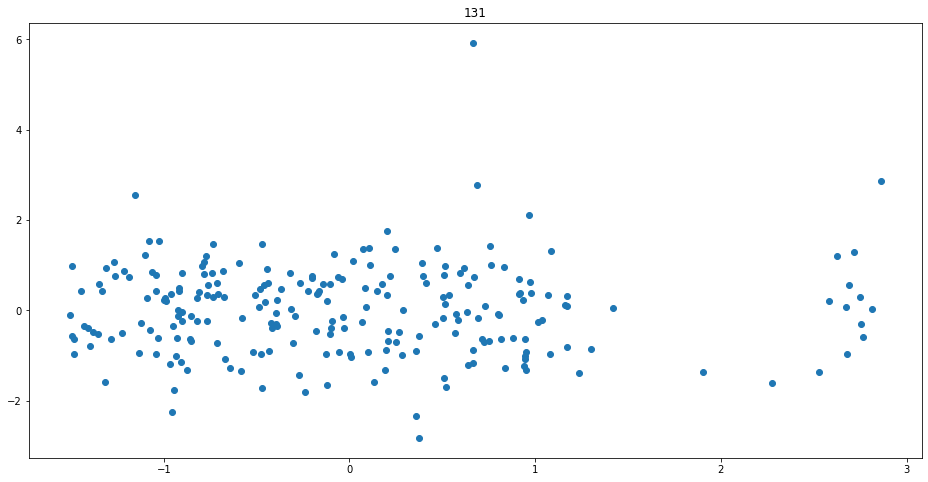

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
26234           26235        247              10133         3654    12  55178   

       fraud_flag  
26234           0  


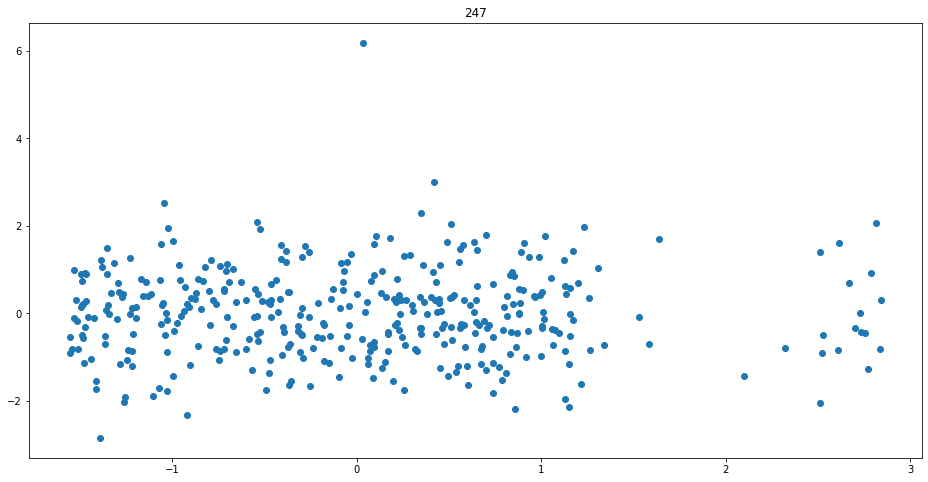

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
75008           75009        266                565         2299    35  60314   

       fraud_flag  
75008           0  


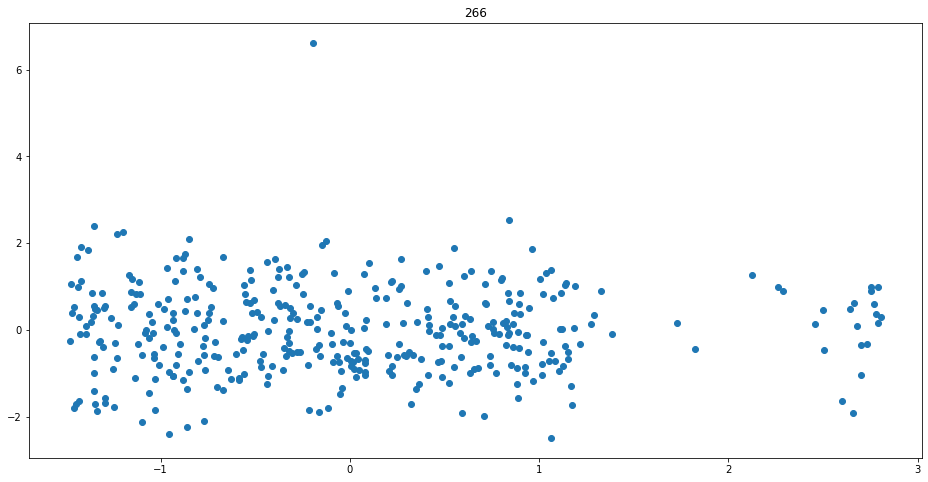

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
93973           93974        325              38025         2293    44  59054   

       fraud_flag  
93973           0  


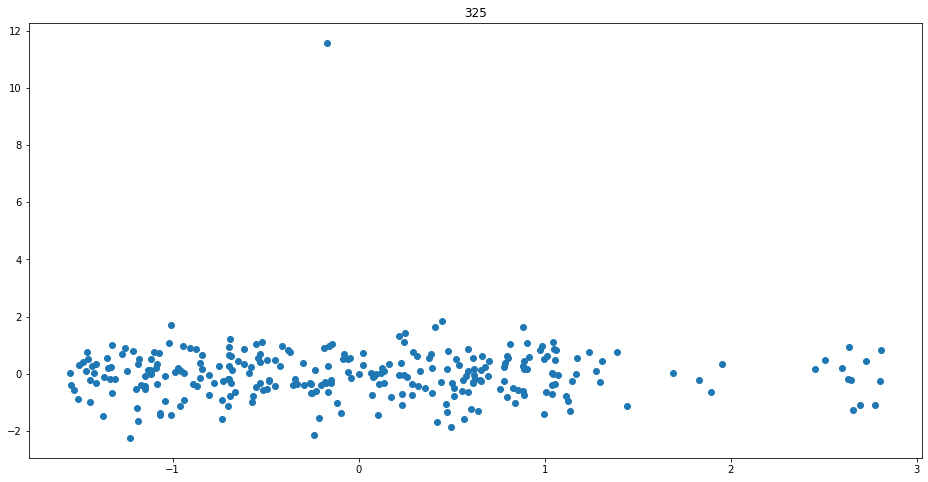

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
28474           28475        385               9775         3077    13  58435   

       fraud_flag  
28474           0  


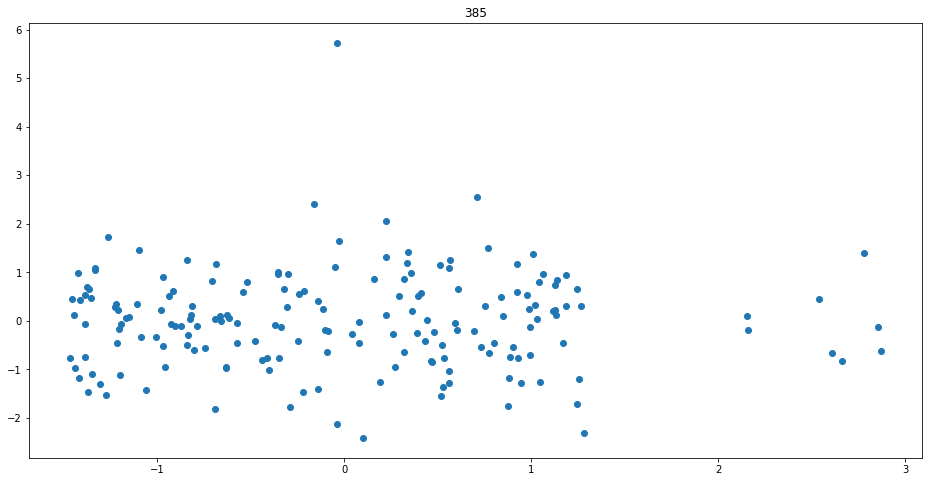

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
27570           27571        412               5674         4894    13  34074   

       fraud_flag  
27570           0  


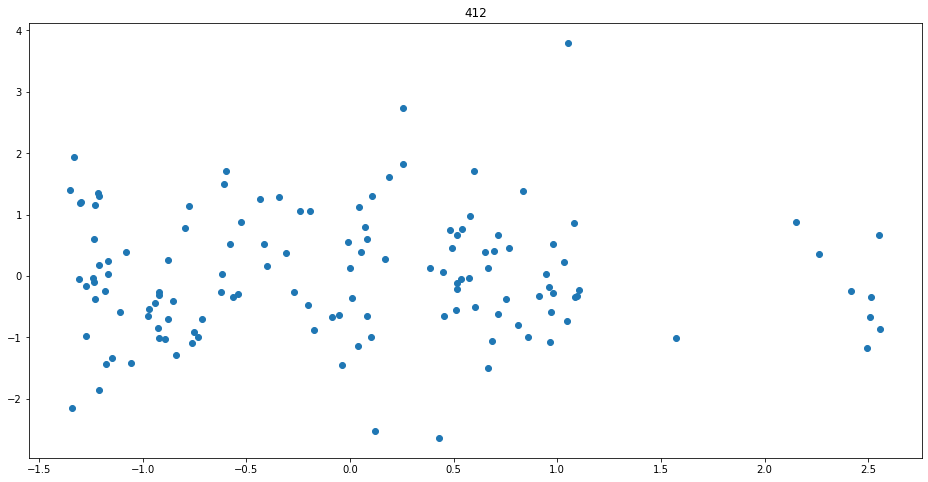

C:\Users\Jon\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


       transaction_id  client_id  transaction_value  merchant_id  date   time  \
38819           38820        414              29582          703    18  51541   

       fraud_flag  
38819           0  


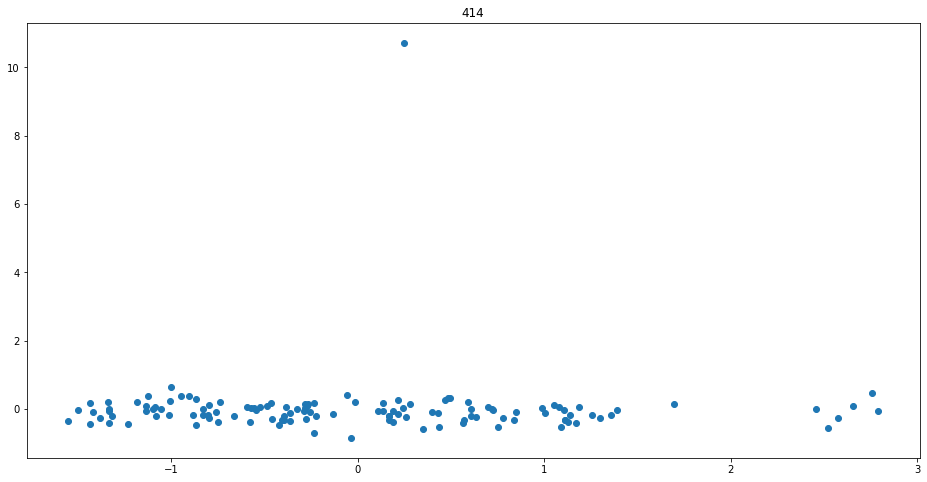

In [89]:
find_fraudulent_transactions(test_data)

When the coursework was given, I was told that there were 8 fraudulent transactions. Following the logic from the training set, I can say with certainty that the following transactions are definitely fraudulent since their PCA y-values are close to or above 6:

1. Transaction 19414 by client 11

1. Transaction 79660 by client 93

1. Transaction 21605 by client 131

1. Transaction 26235 by client 247

1. Transaction 75009 by client 266

1. Transaction 93974 by client 325

1. Transaction 28475 by client 385

1. Transaction 38820 by client 414

I can also say that transaction 27571 by client 412 is almost certainly not fraudulent, despite being made by a multiband client since the PCA y-value is less than 4.

Had I not been told that there were 8 fraudulent transactions, client 28 would have been an interesting case since this was the only case where transactions were made in all three price bands. If I were working on behalf of a real world bank, I would err on the side of caution and flag this as fraud but within the confines of this work, I suspect that this client was simply formed from a quirk in the code generating the transactions.